In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm, matplotlib.font_manager as fm
sns.set(style="darkgrid")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Getting HUD data on 50% income limits
We will use these limits to calculate affordable rents at those levels


In [24]:
bayareafips_full ={'001':'Alameda', '013':'Contra Costa', '041':'Marin', '055':'Napa', '075':'San Francisco', '081':'San Mateo', '085':'Santa Clara', '097':'Sonoma', '095':'Solano'}
bayareafips_full

{'001': 'Alameda',
 '013': 'Contra Costa',
 '041': 'Marin',
 '055': 'Napa',
 '075': 'San Francisco',
 '081': 'San Mateo',
 '085': 'Santa Clara',
 '095': 'Solano',
 '097': 'Sonoma'}

In [12]:
bayareafips_full ={'001':'ala', '013':'cnc', '041':'mar', '055':'nap', '075':'sfr', '081':'smt', '085':'scl', '097':'son', '095':'sol'}
bayareafips_full
inv_map = {v: k for k, v in bayareafips_full.items()}

In [13]:
inv_map

{'ala': '001',
 'cnc': '013',
 'mar': '041',
 'nap': '055',
 'scl': '085',
 'sfr': '075',
 'smt': '081',
 'sol': '095',
 'son': '097'}

## Get data from HUD page
This is not an API call but a direct parsing of the HTML. A bit clunky and probably not future stable.

In [14]:
out = []
for fips in bayareafips_full.keys():
#for fips in ['085']:   
    url='http://www.huduser.org/portal/datasets/il/il2014/2014IlCalc.odn?fips=06{}99999&type=county&year=2014&yy=14&statefp=6'.format(fips)
    t=pd.read_html(url)
    d = {}
    
    ## strangely, a few counties are structured slightly differently, 
    ## so the data is located at a different offsets. This could totally change.
    
    if fips in ['085','097','095']:
        d[fips]=t[5]
    else:
        d[fips]=t[4]
    out.append(d)

In [35]:
t[4]

,0,1,2,3
0,FY2013 4 Person VLIL,Change,Comparison,Final FY2014 4 Person VLIL
1,"$39,250","$38,450 / $39,250 - 1 = -0.02",Is -0.02 < -0.05 or > .05? No,"$38,450"


In [16]:
cols = ['{}-Person'.format(col) for col in range(1,9)]

rows=[]

## out is our list of county-level datasets
for v in out:
    k=v.values()[0]
    if k.shape==(8,9):
        
        ## get rid of the junk rows up top
        k.rename(columns=k.ix[2,:].to_dict(),inplace=True)
        #k=k.ix[k['Income Limit Information']=='FY 2014 FINAL VLIL',cols]
        k=k.ix[7,cols]
        #df=pd.DataFrame(data={'area':k.keys(),'values':k},index=cols)
        s=pd.Series(k,name=v.keys()[0])
        rows.append(s)
    elif k.shape==(2,9):
        k.rename(columns=k.ix[0,:].to_dict(),inplace=True)
        k=k.ix[1,cols]
        s=pd.Series(k,name=v.keys()[0])
        rows.append(s)
    else:
        print k
        #k.rename(columns=k.ix[0,:].to_dict(),inplace=True)
        #k=k.ix[1,cols]
        #s=pd.Series(k,name=v.keys()[0])
        #rows.append(s)
    
limits = pd.concat(rows,axis=1)
limits

,001,013,085,055,081,075,095,041,097
1-Person,"$32,200","$32,200","$35,700","$28,850","$38,750","$38,750","$26,850","$38,750","$26,950"
2-Person,"$36,800","$36,800","$40,800","$33,000","$44,300","$44,300","$30,700","$44,300","$30,800"
3-Person,"$41,400","$41,400","$45,900","$37,100","$49,850","$49,850","$34,550","$49,850","$34,650"
4-Person,"$46,000","$46,000","$50,950","$41,200","$55,350","$55,350","$38,350","$55,350","$38,450"
5-Person,"$49,700","$49,700","$55,050","$44,500","$59,800","$59,800","$41,450","$59,800","$41,550"
6-Person,"$53,400","$53,400","$59,150","$47,800","$64,250","$64,250","$44,500","$64,250","$44,650"
7-Person,"$57,050","$57,050","$63,200","$51,100","$68,650","$68,650","$47,600","$68,650","$47,700"
8-Person,"$60,750","$60,750","$67,300","$54,400","$73,100","$73,100","$50,650","$73,100","$50,800"


In [37]:
## flip the axes
limits=limits.T

## clean the dollar signs and commas
limits=limits.apply(lambda x: x.str.replace('$','').str.replace(',','').astype(np.int64),axis=1)

## take 30% of these income limits--that is our max rent targets
limits_30pct_rent=limits.apply(lambda x: x*.3/12,axis=1)
limits_30pct_rent

,1-Person,2-Person,3-Person,4-Person,5-Person,6-Person,7-Person,8-Person
001,805.00,920.0,1035.00,1150.00,1242.50,1335.00,1426.25,1518.75
013,805.00,920.0,1035.00,1150.00,1242.50,1335.00,1426.25,1518.75
085,892.50,1020.0,1147.50,1273.75,1376.25,1478.75,1580.00,1682.50
055,721.25,825.0,927.50,1030.00,1112.50,1195.00,1277.50,1360.00
081,968.75,1107.5,1246.25,1383.75,1495.00,1606.25,1716.25,1827.50
075,968.75,1107.5,1246.25,1383.75,1495.00,1606.25,1716.25,1827.50
095,671.25,767.5,863.75,958.75,1036.25,1112.50,1190.00,1266.25
041,968.75,1107.5,1246.25,1383.75,1495.00,1606.25,1716.25,1827.50
097,673.75,770.0,866.25,961.25,1038.75,1116.25,1192.50,1270.00


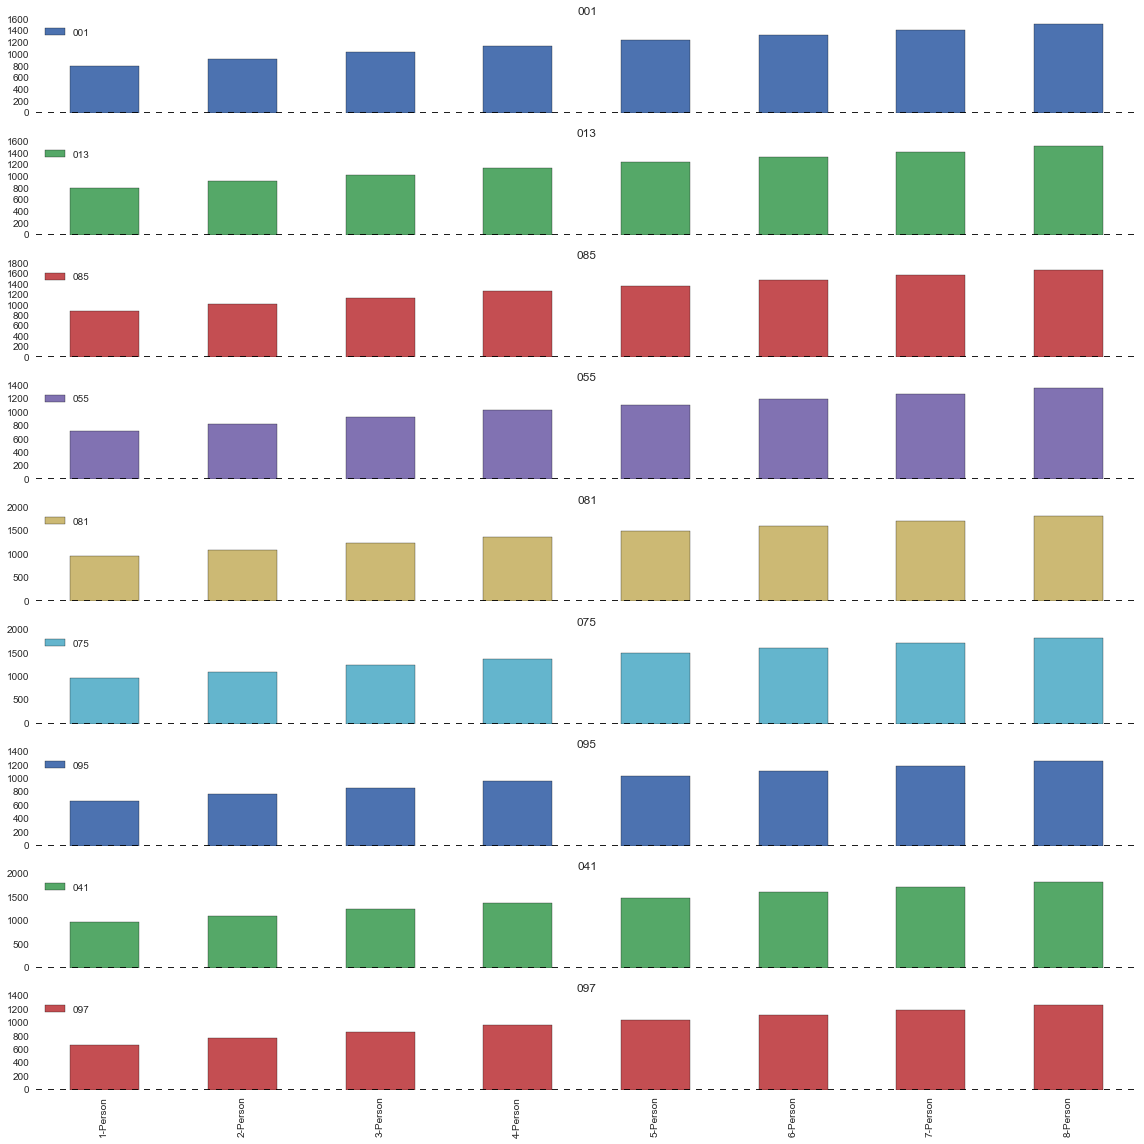

In [38]:
ax = limits_30pct_rent.T.plot(kind='bar',subplots=True,figsize=[16,16]);
plt.tight_layout()

In [39]:
limits_30pct_rent.reset_index().to_csv('/home/aksel/env/ual/bayarea_urbansim/data/hud_50_pct_AMI_rent.csv')

In [40]:
limits_30pct_rent.to_dict()['2-Person']['075']

1107.5

In [41]:
limits_30pct_rent.reset_index(inplace=True)

In [42]:
limits_30pct_rent

,index,1-Person,2-Person,3-Person,4-Person,5-Person,6-Person,7-Person,8-Person
0,001,805.00,920.0,1035.00,1150.00,1242.50,1335.00,1426.25,1518.75
1,013,805.00,920.0,1035.00,1150.00,1242.50,1335.00,1426.25,1518.75
2,085,892.50,1020.0,1147.50,1273.75,1376.25,1478.75,1580.00,1682.50
3,055,721.25,825.0,927.50,1030.00,1112.50,1195.00,1277.50,1360.00
4,081,968.75,1107.5,1246.25,1383.75,1495.00,1606.25,1716.25,1827.50
5,075,968.75,1107.5,1246.25,1383.75,1495.00,1606.25,1716.25,1827.50
6,095,671.25,767.5,863.75,958.75,1036.25,1112.50,1190.00,1266.25
7,041,968.75,1107.5,1246.25,1383.75,1495.00,1606.25,1716.25,1827.50
8,097,673.75,770.0,866.25,961.25,1038.75,1116.25,1192.50,1270.00


In [43]:
## stack it to long form--this might be easier to use for lookup purposes
limits_30pct_rent_lng=pd.melt(limits_30pct_rent,id_vars='index')
limits_30pct_rent_lng['county']=limits_30pct_rent_lng['index'].map(bayareafips_full)
limits_30pct_rent_lng.set_index(['index','county','variable'],inplace=True)
limits_30pct_rent_lng.sort_index(inplace=True)

In [44]:
idx = pd.IndexSlice
limits_30pct_rent_lng.loc[idx[:,['Napa'],:],:]

value
index county variable         
055   Napa   1-Person   721.25
             2-Person   825.00
             3-Person   927.50
             4-Person  1030.00
             5-Person  1112.50
             6-Person  1195.00
             7-Person  1277.50
             8-Person  1360.00

# sandbox

## From SFMOH MOH

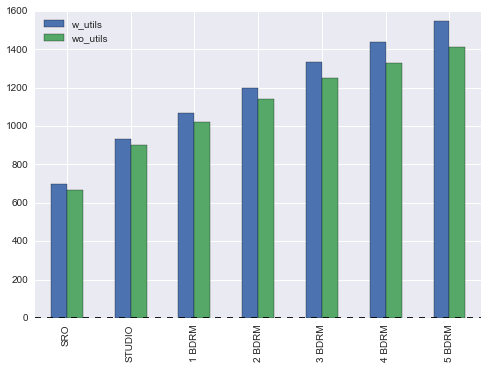

In [27]:
# http://sf-moh.org/modules/showdocument.aspx?documentid=7572
# 2014 MAXIMUM MONTHLY RENT BY UNIT TYPE With and Without Utilities - for MOH singlefamily programs
# 55th percentile selected
## actual data--every other number is FMR w/o utilities. We parse with a slicer next.
l=[700,665 ,934,899 ,1069,1022 ,1201,1139 ,1335,1252 ,1441,1331 ,1549,1412]
sfmoh = pd.DataFrame(data={'w_utils':l[slice(0, 14, 2)],'wo_utils':l[slice(1, 14, 2)]},
             index=['SRO','STUDIO','1 BDRM','2 BDRM','3 BDRM','4 BDRM','5 BDRM']
             )
sfmoh.plot(kind='bar',subplots=False);